## Modeling Protein-Ligand Interactions

#### Use machine learning to model protein-ligand affinity.



Conventionally, high-throughput screening experiments are used to examine bio-activities between drugs and targets, which is a costly and time-consuming procedure. Thus, it is an important alternative to use statistical and machine learning models to estimate the strength of the interactions for novel couples of drug-target, based on the interactions already measured in clinical experiments.



The goal is predict the binding energy of a protein-ligand complex. 


Here I start from molecular docking and then apply machine learning models to predict molecule-ligand affinity.

Molecular docking is a molecular modeling technique that is used to predict how a protein interacts with small molecules. 
Molecular docking performs geometric calculations to find a “binding pose” with a small molecule interacting with a protein in a suitable binding pocket.

ligands are small molecules that bind to proteins (usually non-covalently).



Import libraries

In [1]:
import sys
import deepchem as dc

In [2]:
dc.__version__

'2.5.0'

In [3]:
from rdkit import Chem
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

In [4]:
import os
import pandas as pd
import numpy as np
import wget
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from deepchem.utils import download_url, load_from_disk

In [5]:
from deepchem.utils import download_url, load_from_disk

In [6]:
compound_featurizer = dc.feat.CircularFingerprint(size=128)

In [7]:
import rdkit
rdkit.__version__

'2021.03.5'

### Protein-ligand complex data
Load the protein ligand complex data set ( PDBbind ) . We use  raw_dataset PDB IDs and download pdb directly from Protein Data Bank.The csv file contains SMILES strings of ligands as well as PDB files for the ligand and protein targets from PDBbind. 

In [9]:
## protein database 
data_dir = './'
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

# if not os.path.exists(dataset_file):
#     print('File does not exist. Downloading file...')
#     download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
#     print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]


In [10]:
raw_dataset.head()

,pdb_id,smiles,label
0,2d3u,CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O,6.92
1,3cyx,CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...,8.00
2,3uo4,OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1,6.52
3,1p1q,CC1ONC(O)C1CC([NH3+])C(O)O,4.89
4,3ag9,NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC[NH2...,8.05


### Fixing PDB files

Here we select PDB protein files for visualization and docking. We'll use the PDB IDs from our raw_dataset and download the pdb files directly from the Protein Data Bank using pdbfixer. We'll also sanitize the structures with RDKit. 

In [9]:
from simtk.openmm.app import PDBFile
from pdbfixer import PDBFixer

from deepchem.utils.vina_utils import prepare_inputs

In [10]:
# consider one protein-ligand complex for visualization
pdbid = raw_dataset['pdb_id'].iloc[1]
ligand = raw_dataset['smiles'].iloc[1]

In [11]:
%%time
fixer = PDBFixer(pdbid=pdbid)
PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

p, m = None, None
# fix protein, optimize ligand geometry, and sanitize molecules
try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand)
except:
    print('%s failed PDB fixing' % (pdbid)) 

if p and m:  # protein and molecule are readable by RDKit
    print(pdbid, p.GetNumAtoms())
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  import sys


3cyx 1415
CPU times: user 4.44 s, sys: 282 ms, total: 4.73 s
Wall time: 13.4 s


### Visualization
It is useful to visualize proteins and ligands during splicing. 

In [12]:
import mdtraj as md
import pytraj as pt
import nglview as nv

from IPython.display import display, Image,IFrame

In [13]:
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))

nglview version = 3.0.3
pytraj version = 2.0.5


In [14]:
protein_pttraj = pt.load('3cyx.pdb')
ligand_pttraj = pt.load('ligand_3cyx.pdb')

In [15]:
view = nv.show_pytraj(ligand_pttraj)
view

NGLWidget()

In [16]:
view.render_image()

Image(value=b'', width='99%')

In [17]:
view = nv.show_pytraj(protein_pttraj)
display(view)  #

NGLWidget()

In [18]:
view.render_image()

Image(value=b'', width='99%')

### Molecular Docking

Molecular docking can be used to estimate the binding affinities between our protein ligand systems. Our goal is to identify candidate ligands that strongly interact with a target protein, which is reflected by the score.


DeepChem has a built-in method to identify protein binding pockets. It is based on the convex hull method. The method consists of generating 3D polyhedron (convex hull) around the protein structure and identifying the surface atoms of the nearest convex hull protein.

In [19]:
finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets('3cyx.pdb')
len(pockets)  

37

Pose generation using DeepChem's pose generator

In [20]:
vpg = dc.dock.pose_generation.VinaPoseGenerator()

In [21]:
vpg

In [22]:
!mkdir -p vina_test

In [23]:
complexes, scores = vpg.generate_poses(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'),  # protein-ligand files for docking,
                                       out_dir='vina_test',
                                       generate_scores=True
                                      )

RDKit ERROR: [19:54:18] Explicit valence for atom # 265 C, 5, is greater than permitted
[19:54:18] Explicit valence for atom # 265 C, 5, is greater than permitted
Mol [H]OC1=C([H])C([H])=C(C([H])([H])[C@@]2([H])C(=O)N([H])[C@@]([H])(C([H])([H])C(=O)O)C(=O)N([H])[C@@]([H])(C([H])([H])C([H])([H])C(=O)N([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])

#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Detected 4 CPUs
Reading input ... done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: -38

Vina returns the 9 lowest energy poses it found in units of kcal/mol.

In [24]:
scores

[-9.1, -9.0, -8.9, -8.9, -8.9, -8.9, -8.8, -8.8, -8.6]

combine the molecules into a single RDkit molecule.

In [25]:
complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])

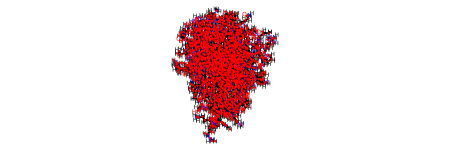

In [26]:
complex_mol

Let's now visualize our complex. We can see that the ligand slots into a pocket of the protein.

In [27]:
v = nv.show_rdkit(complex_mol)
display(v)

NGLWidget()

In [28]:
v.render_image()

Image(value=b'', width='99%')

Docker creates a generator that yields tuples of posed complexes and docking scores.

In [29]:
docker = dc.dock.docking.Docker(pose_generator=vpg)
posed_complex, score = next(docker.dock(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'),
                                          use_pose_generator_scores=True))

RDKit ERROR: [20:08:37] Explicit valence for atom # 265 C, 5, is greater than permitted
[20:08:37] Explicit valence for atom # 265 C, 5, is greater than permitted
Mol [H]OC1=C([H])C([H])=C(C([H])([H])[C@@]2([H])C(=O)N([H])[C@@]([H])(C([H])([H])C(=O)O)C(=O)N([H])[C@@]([H])(C([H])([H])C([H])([H])C(=O)N([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@@]([H])([C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])[C@@]3([H])C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])

#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Detected 4 CPUs
Reading input ... done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 346

In [30]:
score

-9.0

### Modeling Binding Affinity

Docking is a useful, albeit coarse-grained tool for predicting protein-ligand binding affinities. However, it takes some time, especially for large-scale virtual screenings where we might be considering different protein targets and thousands of potential ligands.

In [11]:
pdbids = raw_dataset['pdb_id'].values
ligand_smiles = raw_dataset['smiles'].values

download the PDBbind dataset

In [32]:
%%time
for (pdbid, ligand) in zip(pdbids, ligand_smiles):
    fixer = PDBFixer(url='https://files.rcsb.org/download/%s.pdb' % (pdbid))
    PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))
  
    p, m = None, None
    # skip pdb fixing for speed
    try:
        p, m = prepare_inputs('%s.pdb' % (pdbid), ligand, replace_nonstandard_residues=False,
                          remove_heterogens=False, remove_water=False,
                          add_hydrogens=False)
    except:
        print('%s failed sanitization' % (pdbid)) 

    if p and m:  # protein and molecule are readable by RDKit
        Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
        Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
RDKit ERROR: [20:25:45] UFFTYPER: Unrecognized atom type: S_5+4 (7)
[20:25:45] UFFTYPER: Unrecognized atom type: S_5+4 (7)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecate

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecate

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
RDKit ERROR: [20:29:18] Explicit valence for atom # 388 O, 3, is greater than permitted
[20:29:18] Explicit valence for atom # 388 O, 3,

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecate

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
RDKit ERROR: [20:31:38] UFFTYPER: Unrecognized atom type: S_5+4 (10)
[20:31:38] UFFTYPER: Unrecognized atom type: S_5+4 (10)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
[20:31:40] UFFTYPER: Unrecognized atom type: S_5+4 (6)
RDKit ERROR: [20:31:40] UFFTYPER: Unrecognized atom type: S_5+4 (6)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use th

RDKit ERROR: [20:32:46] UFFTYPER: Unrecognized atom type: S_5+4 (23)
[20:32:46] UFFTYPER: Unrecognized atom type: S_5+4 (23)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
RDKit ERROR: [20:32:49] UFFTYPER: Unrecognized atom type: S_5+4 (22)
[20:32:49] UFFTYPER: Unrecognized atom type: S_5+4 (22)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use 

1hfs failed sanitization


/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  # Remove the CWD from sys.path while we load stuff.
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecate

CPU times: user 5min 31s, sys: 12.3 s, total: 5min 43s
Wall time: 8min 41s


In [12]:
proteins = [f for f in os.listdir('.') if len(f) == 8 and f.endswith('.pdb')]
ligands = [f for f in os.listdir('.') if f.startswith('ligand') and f.endswith('.pdb')]

We'll do some clean up to make sure we have a valid ligand file for every valid protein. The lines here will compare the PDB IDs between the ligand and protein files and remove any proteins that don't have corresponding ligands.

In [13]:
# Handle failed sanitizations
failures = set([f[:-4] for f in proteins]) - set([f[7:-4] for f in ligands])
for pdbid in failures:
    proteins.remove(pdbid + '.pdb')

In [14]:
len(proteins), len(ligands)

(190, 190)

In [15]:
pdbids = [f[:-4] for f in proteins]
small_dataset = raw_dataset[raw_dataset['pdb_id'].isin(pdbids)]
labels = small_dataset.label

we'll need a way to transform our protein-ligand complexes into representations which can be used by learning algorithms

 #### CircularFingerprint

In [37]:
fp_featurizer = dc.feat.CircularFingerprint(size=2048)

In [38]:
features = fp_featurizer.featurize([Chem.MolFromPDBFile(l) for l in ligands])

In [39]:
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

In [40]:
dataset.X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### ML model


Use machine learning techniques increases the accuracy of binding affinity prediction. Random Forest (RF) is the first ML scoring function introducing a substantial improvement over classical scoring functions. ref:https://wires.onlinelibrary.wiley.com/doi/10.1002/wcms.1225



In [20]:
from sklearn.ensemble import RandomForestRegressor

from deepchem.utils.evaluate import Evaluator
import pandas as pd

In [42]:
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

### Evaluate model

the $R^2$ value for the test set indicates that the model isn't producing meaningful outputs. It turns out that predicting binding affinities is hard.

In [43]:
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.939099
RF Test set R^2 0.077041


/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

In [44]:
# Compare predicted and true values
list(zip(model.predict(train_dataset), train_dataset.y))[:5]

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[(6.0682083333333345, 7.4),
 (6.472000000000006, 6.85),
 (4.344249999999997, 3.4),
 (6.586600000000007, 6.72),
 (9.16336666666665, 11.06)]

In [45]:
list(zip(model.predict(test_dataset), test_dataset.y))[:5]

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[(6.730383333333337, 4.21),
 (6.564075, 8.7),
 (5.697975000000002, 6.39),
 (6.640549999999999, 4.94),
 (5.849150000000001, 9.21)]

### The protein-ligand complex view.

In the previous section I just feaurized ligand. Now I want to have our protein-ligand fingerprints. I use the contact fingerprint this time. 



In [16]:
fp_featurizer = dc.feat.ContactCircularFingerprint(size=2048)

features = fp_featurizer.featurize(zip(ligands, proteins))

## There is problem with rdkit failed sanitization : should be fiqgure out I tried version upgrade of rdkit so far but 
#it does not solve problem . suggestion is that in change sanitize = True.


RDKit ERROR: [12:12:51] Explicit valence for atom # 1229 C, 6, is greater than permitted
[12:12:51] Explicit valence for atom # 1229 C, 6, is greater than permitted
Mol CC(C)(C)NC(O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](CC1CCCCC1)NC(O)[C@H](CC(N)O)NC(O)C1CC[C@H]2CCCCC2N1.CC(O)O.CC[C@H](C)[C@@H]1NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O

RDKit ERROR: [12:13:26] Explicit valence for atom # 381 O, 3, is greater than permitted
[12:13:26] Explicit valence for atom # 381 O, 3, is greater than permitted
Mol CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H]([C@@H](C)CC)N1C(=O)[C@@]1(CO)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[

RDKit ERROR: [12:13:43] Explicit valence for atom # 3757 O, 3, is greater than permitted
[12:13:43] Explicit valence for atom # 3757 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)CN

RDKit ERROR: [12:13:51] Explicit valence for atom # 1089 C, 5, is greater than permitted
[12:13:51] Explicit valence for atom # 1089 C, 5, is greater than permitted
Mol CCN(CC)C(O)C1CCC(O)C(OC)C1.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C

RDKit ERROR: [12:15:09] Explicit valence for atom # 180 O, 3, is greater than permitted
[12:15:09] Explicit valence for atom # 180 O, 3, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C

RDKit ERROR: [12:15:27] Explicit valence for atom # 122 O, 3, is greater than permitted
[12:15:27] Explicit valence for atom # 122 O, 3, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O

RDKit ERROR: [12:15:34] Explicit valence for atom # 69 C, 5, is greater than permitted
[12:15:34] Explicit valence for atom # 69 C, 5, is greater than permitted
Mol CCCCCCCCCCCCCCCCCC(O)O.CCO.CCO.CCO.CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CSSC[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC2=O[C@@]23CC(=O)O2N3C2(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)

RDKit ERROR: [12:15:58] Explicit valence for atom # 289 C, 5, is greater than permitted
[12:15:58] Explicit valence for atom # 289 C, 5, is greater than permitted
Mol CCCCCCCCCCCCCC.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@

RDKit ERROR: [12:16:12] Explicit valence for atom # 194 C, 5, is greater than permitted
[12:16:12] Explicit valence for atom # 194 C, 5, is greater than permitted
Mol CC(C)C[C@H](N=C(N)S)C(=O)O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)CN

RDKit ERROR: [12:16:32] Explicit valence for atom # 368 C, 5, is greater than permitted
[12:16:32] Explicit valence for atom # 368 C, 5, is greater than permitted
Mol CC(C)C[C@H](N)C(=O)O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)CNC(=O)[

RDKit ERROR: [12:16:39] Explicit valence for atom # 10 C, 5, is greater than permitted
[12:16:39] Explicit valence for atom # 10 C, 5, is greater than permitted
Mol [H]O[C@]1([H])[C@]2([H])C([H])([H])[C@@]3([H])N([H])[C@]([H])(N([H])C([H])([H])[H])N([H])[C@@]3([H])[C@]([H])(C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])[C@]2([H])N([H])C([H])([H])(N([H])[H])[N+]1([H])[H] failed sanitization
RDKit ERROR: [12:16:50] Explicit valence for atom # 1686 O, 3, is greater than permitted
[12:16:50] Explicit valence for atom # 1686 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@@H](

RDKit ERROR: [12:16:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[12:16:55] Explicit valence for atom # 8 C, 5, is greater than permitted
Mol CC(C)C[C@H](N)C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C=O)CC1=CC=CC=C1)[C@@H](C)O)C(C)C)[C@@H](C)O.CC(C)C[C@H](N)C(=O)N[C@H](C=O)CO.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1C2=OO21)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O

RDKit ERROR: [12:21:01] Explicit valence for atom # 327 O, 4, is greater than permitted
[12:21:01] Explicit valence for atom # 327 O, 4, is greater than permitted
Mol CC(O)O.CCCCCCCCNC1OC[C@@H]2[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)N12.CCCCCCCCNC1OC[C@@H]2[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)N12.CCCCCCCCN[C@H]1OC[C@@H]2[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)N12.CCCCCCCCN[C@H]1OC[C@@H]2[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)N12.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)CNC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=C

RDKit ERROR: [12:21:09] Explicit valence for atom # 343 C, 5, is greater than permitted
[12:21:09] Explicit valence for atom # 343 C, 5, is greater than permitted
Mol CC1NO~[Zn]~O1.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H]1CCC2N1C2(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)N

RDKit ERROR: [12:22:15] Explicit valence for atom # 4499 C, 5, is greater than permitted
[12:22:15] Explicit valence for atom # 4499 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)

RDKit ERROR: [12:22:44] Explicit valence for atom # 1034 O, 3, is greater than permitted
[12:22:44] Explicit valence for atom # 1034 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)C(CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCCCN)[N+]12C(=O)[C@@]13NC(=O)[C@H](CC1=CC=C(O)C=C1)NC14=O56C7(O=C75O16[C@@]4([C@@H](C)O)N1C(=O)[C@@]1(CO)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CC(=O)O)NC1=O[C@@]14C(CCNC(=N)N)N4C(=O)[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]

RDKit ERROR: [12:22:55] Explicit valence for atom # 487 O, 3, is greater than permitted
[12:22:55] Explicit valence for atom # 487 O, 3, is greater than permitted
Mol CC(C)(C)OC(O)N[C@H]1CCCCCCC[C@@H]2C[C@@]2(C(O)NS(O)(O)C2CC2)N[C@H](O)[C@@H]2C[C@@H](OC(O)N3CC4CCCC(F)C4C3)CN2C1O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC1=O2C3C(C)C4C(=O)(N[C@@]132)[C@]4(CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H]

RDKit ERROR: [12:23:10] Explicit valence for atom # 1490 O, 3, is greater than permitted
[12:23:10] Explicit valence for atom # 1490 O, 3, is greater than permitted
Mol CC[C@@H]1C[C@]1(N[C@@H](O)[C@@H]1C[C@@H]2CN1[C@@H](O)[C@H](C(C)(C)C)NC(O)OCC(C)(C)CCCC[C@@H]1CCCC3CN(CC31)C(O)O2)C(O)NS(O)(O)C1CC1.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC

RDKit ERROR: [12:24:21] Explicit valence for atom # 1458 O, 3, is greater than permitted
[12:24:21] Explicit valence for atom # 1458 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1C2CC(N)=OOC(=O2)C2C34[C@H](NC(=O)[C@@H]5CCCN5C(=O)[C@H](CCCCN)NC(=O)[C@@H]5CCCN5C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC5=CC=CC=C5)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]5CCCN5C(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@@H]5CCCN5C(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC5=CC=C(O)C=C5)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H

RDKit ERROR: [12:24:28] Explicit valence for atom # 1205 O, 3, is greater than permitted
[12:24:28] Explicit valence for atom # 1205 O, 3, is greater than permitted
Mol CC(O)N[C@H]1CO[C@H](CO)[C@@H](O)[C@@H]1O.CC1NC2NC([C@H](O)N3CCOCC3)CN2[C@@H](C2CCC(Cl)CC2Cl)[C@@H]1CN.CC1NC2N[C@H]([C@H](O)N3CCOCC3)CN2[C@@H](C2CCC(Cl)CC2Cl)[C@@H]1CN.CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C(C)C)NC(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C

RDKit ERROR: [12:24:53] Explicit valence for atom # 1576 C, 5, is greater than permitted
[12:24:53] Explicit valence for atom # 1576 C, 5, is greater than permitted
Mol CC[C@H](C)[C@@H](C=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CCSC)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCCN)N

RDKit ERROR: [12:25:01] Explicit valence for atom # 1568 C, 6, is greater than permitted
[12:25:01] Explicit valence for atom # 1568 C, 6, is greater than permitted
Mol C=[C@@](C=C1=C=C=C(=O=P(=O)(=O)O)=C=C=1)(=[N+]=C(=O)=C(=C=C1=C=C=C(=O=P(=O)(=O)O)=C=C=1)=[N+]=C(=O)=O=C=C1=C=C=C=C(=N)=C=1)=C(=O)=N[C@@H](CC(N)=O)C(=O)O.C=[C@@](C=C1=C=C=C(=O=P(=O)(=O)O)=C=C=1)(=[N+]=C(=O)=C(=C=C1=C=C=C(=O=P(=O)(=O)O)=C=C=1)=[N+]=C(=O)=O=C=C1=C=C=C=C(=N)=C=1)=C(=O)=N[C@@H](CC(N)=O)C(=O)O.CC[C@H](C)[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[

RDKit ERROR: [12:25:40] Explicit valence for atom # 1522 C, 6, is greater than permitted
[12:25:40] Explicit valence for atom # 1522 C, 6, is greater than permitted
Mol C=C(=O=P(=O)(=O)O)=C(=[N+]=C(O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC

RDKit ERROR: [12:25:47] Explicit valence for atom # 270 O, 4, is greater than permitted
[12:25:47] Explicit valence for atom # 270 O, 4, is greater than permitted
Mol CC[C@@H]1C[C@]1(NC(O)[C@@H]1C[C@@H]2CN1[C@@H](O)[C@H](C(C)(C)C)N[C@H](O)OCC(C)(C)CCCC[C@H]1CCCC3CN(CC31)C(O)O2)[C@@H](O)NS(O)(O)C1CC1.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1NC([C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC

RDKit ERROR: [12:25:53] Explicit valence for atom # 2716 O, 3, is greater than permitted
[12:25:53] Explicit valence for atom # 2716 O, 3, is greater than permitted
Mol CCC(O)NC1CCC2C(C1)NC(C1CCCCC1)NC2NC1CCNN1.CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O.CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CS)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](CC(=

RDKit ERROR: [12:26:03] Explicit valence for atom # 102 O, 3, is greater than permitted
[12:26:03] Explicit valence for atom # 102 O, 3, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O

RDKit ERROR: [12:26:21] Explicit valence for atom # 457 O, 3, is greater than permitted
[12:26:21] Explicit valence for atom # 457 O, 3, is greater than permitted
Mol CC(C)[C@H](NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@]1(N)O[C@H]1C)C(=O)N[C@H](C(=O)N[C@H](C=O)CC1=CC=CC=C1)[C@@H](C)O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1CC1N)NC(=O)[C@H](CCCNC(=N)N)NC12=OO13CC23NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=

RDKit ERROR: [12:26:40] Explicit valence for atom # 1712 C, 5, is greater than permitted
[12:26:40] Explicit valence for atom # 1712 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CS)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC(C

RDKit ERROR: [12:26:43] Explicit valence for atom # 165 O, 5, is greater than permitted
[12:26:43] Explicit valence for atom # 165 O, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CS)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC(C)C

RDKit ERROR: [12:29:44] Explicit valence for atom # 986 O, 3, is greater than permitted
[12:29:44] Explicit valence for atom # 986 O, 3, is greater than permitted
Mol Br.Br.Br.Br.Br.Br.Br.Br.C.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCCN)NC(=O)[C@]1(NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=

RDKit ERROR: [12:31:39] Explicit valence for atom # 1932 O, 4, is greater than permitted
[12:31:39] Explicit valence for atom # 1932 O, 4, is greater than permitted
Mol Br.Br.Br.Br.Br.Br.Br.Br.Br.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC

RDKit ERROR: [12:31:48] Explicit valence for atom # 1064 C, 5, is greater than permitted
[12:31:48] Explicit valence for atom # 1064 C, 5, is greater than permitted
Mol CC1NCN[C@H]2[C@H]1NCN2[C@@H]1O[C@H](CCCN[C@H](O)[C@H]2CC(C3CCC(F)CC3)CC3O~[MgH2]~O[C@@H]32)[C@@H](O)[C@H]1O.CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CC(SC)O=C([C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@@H](NC(=O)[C@H](CS)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCC[N+]23C245OC26O=C634[C@@H]5NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@

RDKit ERROR: [12:32:12] Explicit valence for atom # 4247 O, 3, is greater than permitted
[12:32:12] Explicit valence for atom # 4247 O, 3, is greater than permitted
Mol CC(O)N[C@H]1C(NOC(O)NC2CCCCC2)O[C@H](CO)[C@@H](O)[C@@H]1O.CC(O)N[C@H]1C(NOC(O)NC2CCCCC2)O[C@H](CO)[C@@H](O)[C@@H]1O.CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(

RDKit ERROR: [12:32:18] Explicit valence for atom # 88 C, 5, is greater than permitted
[12:32:18] Explicit valence for atom # 88 C, 5, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H]2CCCN2C(=O)CNC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@@H]2CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H]3CCCN3C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]3CCCN3C(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(

RDKit ERROR: [12:32:28] Explicit valence for atom # 282 O, 3, is greater than permitted
[12:32:28] Explicit valence for atom # 282 O, 3, is greater than permitted
Mol CCC1[C@@H]2CC(C)C[C@@]1(N)C1CCC(O)NC1C2.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@

RDKit ERROR: [12:32:35] Explicit valence for atom # 4333 O, 3, is greater than permitted
[12:32:35] Explicit valence for atom # 4333 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CS)NC(=O)[C@H](CS)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](CS)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)CNC(=O)[C@H](CCSC)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CNC2=C1C

RDKit ERROR: [12:32:39] Explicit valence for atom # 431 O, 3, is greater than permitted
[12:32:39] Explicit valence for atom # 431 O, 3, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](C)NC(=O)[C@@H]2CSSC[C@@H]3NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC4=CC=C(O)C=C4)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC4=CNC=N4)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC4=CC=

RDKit ERROR: [12:34:47] Explicit valence for atom # 484 C, 5, is greater than permitted
[12:34:47] Explicit valence for atom # 484 C, 5, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](C(C)C)NC(=O)CNC(=O)CNC(=O)[C@@H]2CCCN2C(=O)CNC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCSC)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H]([C

RDKit ERROR: [12:34:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:34:50] Explicit valence for atom # 1 C, 5, is greater than permitted
Mol [H]ON([H])C([H])([H])(N([H])[H])N([H])C([H])([H])C([H])([H])[C@]([H])(C([H])(O[H])O[H])[N+]([H])([H])[H] failed sanitization
RDKit ERROR: [12:35:45] Explicit valence for atom # 1389 C, 7, is greater than permitted
[12:35:45] Explicit valence for atom # 1389 C, 7, is greater than permitted
Mol CC(C)C[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCN1NC1=N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C=O)CC1=CC=CC=C1)C(C)C)C(C)C.CC(C)C[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC1=ON23(C(=N)N)CC2C3[C@@H]1N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@H](C(=O)N

RDKit ERROR: [12:36:01] Explicit valence for atom # 551 O, 3, is greater than permitted
[12:36:01] Explicit valence for atom # 551 O, 3, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC23=CC=C(O)C2=C3)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCSC)NC(=O)[

RDKit ERROR: [12:36:10] Explicit valence for atom # 68 O, 3, is greater than permitted
[12:36:10] Explicit valence for atom # 68 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H]1CCCNC(=N)[N+]23O=C2([C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]2CC4CCNC5=CC(=CC=C5O)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)[N+]56C7C89O=C8([C@@]9(NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]8C(O)N8C(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC8=O[C@]8(CCC(N)=O)NC(=O)[C@H](CC8=CC=CC=C8)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC8=CC=CC=C8)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@@H](N)CCSC)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)O)[C@@H](C)CC)[N+]89CC785%10[C@H]9C6%10=O)[C@@H](C)O)C(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O4)N2)[C@@H](C)CC)N3[C@@H]([C@@H](C)CC)C(=

RDKit ERROR: [12:36:33] Explicit valence for atom # 1055 O, 3, is greater than permitted
[12:36:33] Explicit valence for atom # 1055 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)NCC(=O)NCC(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@H](C(=O)N[C@H]1CSSC[C@@H]2NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]3CCCN3C(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)[C@H](CC3=CNC4=C3C=CC=C4)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]3CSSC[C@@H]4NC(=O)[C@H](C(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@@H]5CCCN5C(=O)CNC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CSSC[C@H](NC(=O)CNC(=O)[C@@H](CO)NC(=O)CNC(=O)[C@H](CC5=CNC6=C5C=CC=C6)NC(=O)[C@H](CO)NC(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O

RDKit ERROR: [12:37:06] Explicit valence for atom # 1064 O, 3, is greater than permitted
[12:37:06] Explicit valence for atom # 1064 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CS)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H

RDKit ERROR: [12:37:13] Explicit valence for atom # 1837 O, 3, is greater than permitted
[12:37:13] Explicit valence for atom # 1837 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)NCC(=O)NCC(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@H]1CSSC[C@@H](C(=O)N2CCC[C@H]2C(=O)N[C@@H](CC2=CNC3=C2C=CC=C3)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@H]2CSSC[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC3=CC=C(O)C=C3)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC3=CC=CC=C3)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)NCC(=O)N[C@@

RDKit ERROR: [12:37:26] Explicit valence for atom # 21 C, 5, is greater than permitted
[12:37:26] Explicit valence for atom # 21 C, 5, is greater than permitted
Mol [H]ON([H])C1([H])([H])N([H])[C@@]([H])(C([H])([H])O[H])[C@@]([H])(O[C@]2([H])O[C@]([H])(C([H])([H])O[H])[C@]([H])(O[C@@]3([H])O[C@]([H])(C([H])([H])O[H])[C@]([H])(OC([H])([H])[H])[C@]([H])(O[H])[C@@]3([H])O[H])[C@]([H])(O[H])[C@]2([H])O[H])[C@@]([H])(O[H])[C@@]1([H])O[H] failed sanitization
RDKit ERROR: [12:37:58] Explicit valence for atom # 2816 C, 5, is greater than permitted
[12:37:58] Explicit valence for atom # 2816 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)

RDKit ERROR: [12:38:47] Explicit valence for atom # 640 C, 5, is greater than permitted
[12:38:47] Explicit valence for atom # 640 C, 5, is greater than permitted
Mol CC(C)(C)C1CCC([C@@H](O)C[C@H]2CC[C@@H](O)[C@@H]3[C@@H]4O~[Zn]~O[C@@H]4CN23)CC1.CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CO)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C(C)

RDKit ERROR: [12:38:51] Explicit valence for atom # 126 O, 3, is greater than permitted
[12:38:51] Explicit valence for atom # 126 O, 3, is greater than permitted
Mol CC1CNCC2CCC[C@@H](S(O)(O)N3CCCNC[C@@H]3C)C12.CC1CNCC2CCC[C@H](S(O)(O)N3CCCNC[C@@H]3C)C12.CCCCCCCC.CC[C@H](C)[C@H](N=C(O)[C@H](CO[PH](O)(O)O)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)

RDKit ERROR: [12:39:35] Explicit valence for atom # 1010 C, 5, is greater than permitted
[12:39:35] Explicit valence for atom # 1010 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CS)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)CN

RDKit ERROR: [12:39:44] Explicit valence for atom # 132 O, 3, is greater than permitted
[12:39:44] Explicit valence for atom # 132 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@H](CS)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]1CC(=O)OCC(C)[C@@H](NC(=O)[C@@H]2CC3(=O)NS3(C)CC[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC3=CNC

RDKit ERROR: [12:39:58] Explicit valence for atom # 343 C, 5, is greater than permitted
[12:39:58] Explicit valence for atom # 343 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H]1CCC2N1C2(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@@H](NC

RDKit ERROR: [12:40:00] Explicit valence for atom # 11 C, 5, is greater than permitted
[12:40:00] Explicit valence for atom # 11 C, 5, is greater than permitted
Mol [H]O[C@]1([H])C([H])([H])C([H])([H])N2[C@]1([H])[C@@]([H])(C(F)(F)F)OC2([H])([H])N([H])[C@]1([H])C([H])([H])C([H])([H])[C@]([H])(C([H])([H])N([H])[H])[C@]([H])(Cl)[C@@]1([H])C([H])([H])[H] failed sanitization
RDKit ERROR: [12:40:03] Explicit valence for atom # 2037 O, 3, is greater than permitted
[12:40:03] Explicit valence for atom # 2037 O, 3, is greater than permitted
Mol CC1C(NC2O[C@@H](C(F)(F)F)[C@@H]3[C@@H](O)CCN23)CCC(CN)C1Cl.CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)CCC(N)=O)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CS)C(=O)N[C@@H](C)C(=O)NCC(=O)N[C@@H](CC1=CNC=N1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(N)=O)C(=O)N

RDKit ERROR: [12:40:17] Explicit valence for atom # 282 O, 3, is greater than permitted
[12:40:17] Explicit valence for atom # 282 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=CC=C1)N

RDKit ERROR: [12:40:25] Explicit valence for atom # 902 C, 5, is greater than permitted
[12:40:25] Explicit valence for atom # 902 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)NCC(=O)NCC(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@H](C(=O)N[C@H]1CSSC[C@@H]2NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]3CCCN3C(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CO)NC3=O45C67CC89%10NN8C9(=O)C[C@H](NC(=O)CNC(=O)[C@H](CC8=CNC9=C8C=CC=C9)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]8CSSC[C@@H]9NC(=O)[C@H](C(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@@H]%11CCCN%11C(=O)CNC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CSSC[C@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CC%11=CNC%12=C%11C=CC=C%12)NC(=O)[C@H](CO)NC(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CO)NC

RDKit ERROR: [12:40:35] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:40:35] Explicit valence for atom # 1 C, 5, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC

RDKit ERROR: [12:40:38] Explicit valence for atom # 728 C, 5, is greater than permitted
[12:40:38] Explicit valence for atom # 728 C, 5, is greater than permitted
Mol CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](C(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)[C@H](CC2=CNC=N2)NC(=O)

RDKit ERROR: [12:41:44] Explicit valence for atom # 699 O, 3, is greater than permitted
[12:41:44] Explicit valence for atom # 699 O, 3, is greater than permitted
Mol CC(O)O.CC[C@H](C)[C@H](NC(=O)C(CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C12=O3C(C)(C)C314[C@@H]2N4C(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC1=CNC=

RDKit ERROR: [12:41:47] Explicit valence for atom # 1622 O, 3, is greater than permitted
[12:41:47] Explicit valence for atom # 1622 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C

RDKit ERROR: [12:41:50] Explicit valence for atom # 820 C, 5, is greater than permitted
[12:41:50] Explicit valence for atom # 820 C, 5, is greater than permitted
Mol CC(O)N[C@@H](CC1CCC(O[PH](O)(O)O)CC1)C(O)NC1(C(O)=N[C@@H](CC(N)=O)C(N)=O)CC1.CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CCSC)[C@@H](C)CC)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O)N

RDKit ERROR: [12:42:12] Explicit valence for atom # 567 O, 3, is greater than permitted
[12:42:12] Explicit valence for atom # 567 O, 3, is greater than permitted
Mol CC(O)O.CC(O)O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)CNC(=O)CNC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H]1CSSC[C@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@@H](NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)CNC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)C234CO5OC5[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)CNC5=O[C@]5(CO)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CC5=CNC6=C5C=CC=C6)NC(=O)[C@H](CC5=CC=C(O)C=C5)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)[C@@H]5CCCN5C(=O)[C@H](CC(C)C)NC(=O)[C@H](CC5=CC=C(O)C=C5)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)CNC(=O)[C@@]5(CC(=O)O)NC5(=O)[C@@H](NC(=O)[C@H](CO)

RDKit ERROR: [12:42:57] Explicit valence for atom # 34 O, 4, is greater than permitted
[12:42:57] Explicit valence for atom # 34 O, 4, is greater than permitted
Mol CCCCCCCCCCCC(O)O.CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H](C1=O2C(SC)C2[C@@H](C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)NCC(=O)N[C@H](C(=O)N[C@@H](CC2=CNC3=C2C=CC=C3)C(=O)N[C@@H](CC2=CC=C(O)C=C2)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@@H](CC2=CC=C(O)C=C2)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N2

RDKit ERROR: [12:43:03] Explicit valence for atom # 59 O, 3, is greater than permitted
[12:43:03] Explicit valence for atom # 59 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](N)C(=O)NC1C(=O)NCC(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CC2=CNC3=C2C=CC=C3)C(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CC2=CC=C(O)C=C2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC2=CNC=N2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](CC2=CC=C(O)C=C2)C(=O)N[C@@H](C(C)C)C(=O)N[C@H]2CSSC[C@@H]3NC(=O)[C@H](CC4=CNC=N4)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC4=CNC5=C4C=CC=C5)NC(=O)[C@H](CSSC[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@H]

RDKit ERROR: [12:43:14] Explicit valence for atom # 41 C, 5, is greater than permitted
[12:43:14] Explicit valence for atom # 41 C, 5, is greater than permitted
Mol CCCCCCCCCC(O)O.CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CSSC[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC2=CNC3=C2C=CC=C3)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@]23NC4=O5OC5(=O256CC5(C)C36)CC[C@@]2(NC(=O)[C@@H](NC(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]3CCCN3C(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C)NC(=O)C(CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](NC3=OC56[C@@H]3N53(C(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C

RDKit ERROR: [12:43:37] Explicit valence for atom # 2122 O, 3, is greater than permitted
[12:43:37] Explicit valence for atom # 2122 O, 3, is greater than permitted
Mol CC(C)C[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C=O)CC1=CC=CC=C1)C(C)C)C(C)C.CC(C)C[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C=O)CC1=CC=CC=C1)C(C)C)C(C)C.CC(O)N[C@H]1[C@H](O)CN[C@H](CO)[C@@H](O)[C@@H]1O.CC(O)N[C@H]1[C@H](O)CN[C@H](CO)[C@@H](O)[C@@H]1O.CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C

RDKit ERROR: [12:43:44] Explicit valence for atom # 132 O, 3, is greater than permitted
[12:43:44] Explicit valence for atom # 132 O, 3, is greater than permitted
Mol CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H](NC(=O)[C@H](CS)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCC[N+]12O1[C@@]3(C)[C@@H](NC(=O)CNC(=O)[C@@H]4CCCN4C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC4=O[C@]4(CC(C)C)NC(=O)[C@@H](NC(=O

In [18]:
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

In [25]:
train_dataset.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

In [22]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.497277
RF Test set R^2 0.019109


In [23]:
# Compare predicted and true values
list(zip(model.predict(train_dataset), train_dataset.y))[:5]

[(7.011099999999994, 7.4),
 (6.601207122012839, 6.85),
 (5.879433700592736, 3.4),
 (5.879433700592736, 6.72),
 (9.147399999999987, 11.06)]

In [24]:
list(zip(model.predict(test_dataset), test_dataset.y))[:5]

[(5.879433700592736, 4.21),
 (5.879433700592736, 8.7),
 (5.879433700592736, 6.39),
 (5.879433700592736, 4.94),
 (6.407842206749803, 9.21)]

### Using dc.molnet data


The convenience loader dc.molnet.load_pdbbind will take care of downloading and featurizing the pdbbind dataset under the hood for us. For the rest of this task I used dc.molnet.load_pdbbind.

Workflow 

* Loading a chemical dataset, consisting of a series of protein-ligand complexes.
* Featurizing each protein-ligand complexes with the fp featurization scheme.
* Fitting models with these featurized protein-ligand complexes.



In [46]:
fp_featurizer = dc.feat.ContactCircularFingerprint(size=2048)

In [47]:


tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer= fp_featurizer ,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')


RDKit ERROR: [20:37:39] Explicit valence for atom # 190 C, 6, is greater than permitted
[20:37:39] Explicit valence for atom # 190 C, 6, is greater than permitted
Mol [H]N=C(=C=O)=C=C=C=C=N([H])([H])=C=C1=C(=C=O=P(=O)(=O)O)=C=[N+]=C(=C)=C=1=O.[H]NCC(=O)N([H])CC(=O)N([H])[C@@H](CC(C)C)C(=O)N([H])CC=O.[H]N[C@@H](CC(=O)O)C(=O)N([H])[C@@H](CC(=O)N([H])[H])C(=O)N([H])[C@H](C=O)CC1=CC=CC=C1.[H]N[C@@H](CC1=CC=C(O[H])C=C1)C(=O)N([H])[C@H](C=O)CCCC[N+]([H])([H])[H].[H]N[C@@H](CC1=CNC=N1)C(=O)N([H])[C@H](C=O)[C@@H](C)O[H].[H]N[C@@H](CCC(=O)O)C(=O)N([H])[C@@H](C)C(=O)N([H])[C@@H](CO[H])C(=O)N([H])CC(=O)N([H])[C@H](C=O)[C@@H](C)O[H].[H]N[C@H](C=O)C(C)C.[H]N[C@H](C=O)CC(=O)N([H])[H].[H]N[C@H](C=O)CC(=O)O.[H]N[C@H](C=O)CC(C)C.[H]N[C@H](C=O)CC1=CNC=N1 failed sanitization
RDKit ERROR: [20:38:10] Explicit valence for atom # 197 C, 6, is greater than permitted
[20:38:10] Explicit valence for atom # 197 C, 6, is greater than permitted
Mol [H]N=C(=C=O)=C=C=C=C=N([H])([H])=C=C1=C(=C=O=P(=O)(=O)O)=C=[N+]=C(

In [49]:
train, valid , test = datasets

### ML model

Use RF ML model.

In [50]:
train.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
seed = 42 # Set a random seed to get stable results
# sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
# sklearn_model.random_state = seed
# model = dc.models.SklearnModel(sklearn_model)
# model.fit(train_dataset)

sklearn_model = RandomForestRegressor(n_estimators=100,max_features='sqrt')
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)

### Evaluation

In [54]:
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.961072
RF Test set R^2 0.100876


/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

It looks like I get lower accuracy here. 

In [55]:
# Compare predicted and true values
list(zip(model.predict(train), train.y))[:5]

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[(-0.507147453663166, -0.9123196243775895),
 (-0.05943902314189908, -0.27449566657071384),
 (0.4929605121780141, 0.7768141673316538),
 (0.8551565444940015, 1.5290065589521755),
 (-0.13509814089554203, -0.019366083447963603)]

In [56]:
list(zip(model.predict(test), test.y))[:5]

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[(0.1348553507638229, 0.42491129405889444),
 (-0.2295840623692779, -1.7612853061481206),
 (-0.7977752391273064, 0.455702795470261),
 (0.08193795619543177, 1.1287170406044122),
 (0.053301859882861014, 1.005551034958947)]

use hyperparameter searching to find a higher scoring ligands.

In [ ]:
def rf_model_builder(model_params, model_dir):
    sklearn_model = RandomForestRegressor(**model_params)
    return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [10, 50, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

## NN model


Check nn model.

In [57]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils

In [58]:
inputs = Input(shape=(4096,), name='input')
x = Dense(128,activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(8,activation='relu')(x)          
predictions = Dense(1, activation='linear', name='output')(x)
 
model = Model(inputs=inputs, outputs = predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss='mean_squared_error')
                           #metrics=['acc'])

model.summary()
 



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 528,817
Trainable params: 528,817
Non-trainable params: 0
_________________________________________________________________


2021-09-05 20:50:21.883352: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-05 20:50:21.967804: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc7c6c1ff20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-05 20:50:21.967838: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [59]:
train.X.shape

(154, 4096)

In [60]:
train.y.reshape(-1,1).shape

(154, 1)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/tensorflow/python/ops/numpy_ops/np_random.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def randint(low, high=None, size=None, dtype=onp.int):  # pylint: disable=missing-function-docstring


Epoch 1/50
154/154 [==============================] - 1s 3ms/step - loss: 0.9920
Epoch 2/50
154/154 [==============================] - 1s 3ms/step - loss: 0.6630
Epoch 3/50
154/154 [==============================] - 1s 4ms/step - loss: 0.3358
Epoch 4/50
154/154 [==============================] - 1s 4ms/step - loss: 0.2026
Epoch 5/50
154/154 [==============================] - 1s 4ms/step - loss: 0.1342
Epoch 6/50
154/154 [==============================] - 1s 5ms/step - loss: 0.0975
Epoch 7/50
154/154 [==============================] - 1s 4ms/step - loss: 0.0636
Epoch 8/50
154/154 [==============================] - 1s 4ms/step - loss: 0.0493
Epoch 9/50
154/154 [==============================] - 1s 5ms/step - loss: 0.0517
Epoch 10/50
154/154 [==============================] - 1s 4ms/step - loss: 0.0562
Epoch 11/50
154/154 [==============================] - 1s 4ms/step - loss: 0.0544
Epoch 12/50
154/154 [==============================] - 1s 4ms/step - loss: 0.0435
Epoch 13/50
154/154 [====

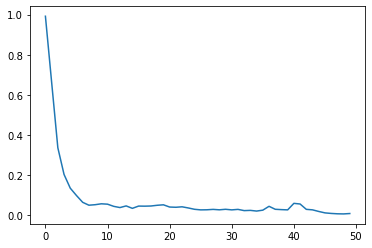

In [61]:
epochs = 50
hist = model.fit(train.X, train.y, batch_size=1, epochs=epochs)
plt.plot(range(epochs), hist.history['loss'])

In [64]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Predicting
pred_train = model.predict(train.X)
pred_test = model.predict(test.X)


# Scores of Train Data 
tr_mae = mean_absolute_error(train.y, pred_train)
tr_rmse = mean_squared_error(train.y ,pred_train , squared=False)
tr_r2 = r2_score(train.y ,pred_train)
print('##########################  Scores of Train Data  ##########################')
print('Train set MAE of {}: {:.3f}'.format(model, tr_mae))
print('Train set RMSE of {}: {:.3f}'.format(model, tr_rmse))
print('Train set R2 Score of {}: {:.3f}'.format(model, tr_r2))

test_mae = mean_absolute_error(test.y, pred_test)
test_rmse = mean_squared_error(test.y, pred_test, squared=False)
test_r2 = r2_score(test.y, pred_test)
print('##########################  Scores of Test1 Data  ##########################')
print('Test set MAE of {}: {:.3f}'.format(model, test_mae))
print('Test set RMSE of {}: {:.3f}'.format(model, test_rmse))
print('Test set R2 Score of {}: {:.3f}'.format(model, test_r2))

##########################  Scores of Train Data  ##########################
Train set MAE of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: 0.064
Train set RMSE of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: 0.101
Train set R2 Score of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: 0.990
##########################  Scores of Test1 Data  ##########################
Test set MAE of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: 0.785
Test set RMSE of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: 0.920
Test set R2 Score of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc7c9d84910>: -0.315


I obtain worse results for test data. Train data show overfittng resulst. It seems I need to tune hyperparameter.



## Atomic convolutional networks for predicting protein-ligand binding affinity

The atomic convolutional networks function as a variant of graph convolutions. The difference is that the “graph” here is the nearest neighbors graph in 3D space. The AtomicConvModel leverages these connections in 3D space to train models that learn to predict energetic state starting from the spatial geometry of the model. https://arxiv.org/abs/1703.10603

In [65]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

In [74]:
# features = acf.featurize(zip(ligands, proteins))
# dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
# #train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)


In [66]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [67]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['3b68' '3ge7' '1e66' ... '3dd0' '3mfv' '2brb'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['2xb8' '3l4u' '2j78' ... '3gbb' '3pww' '3cft'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2zx6' '1mq6' '1f8d' ... '3cj2' '3su2' '3fk1'], task_names: [0]>)

In [68]:
train, val, test = datasets

In [69]:
# splitter = dc.splits.RandomSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
#   dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2,seed =42)

In [70]:
train.y[:5]

array([ 0.95527678,  1.08832208,  1.61606844, -1.14683898,  0.46744401])

## Training the model

Now we've got our dataset, we initialize an AtomicConvModel to train. Keep the input parameters the same as those used in AtomicConvFeaturizer. layer_sizes controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the original paper.

In [71]:
acm = dc.models.AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003)

In [72]:
losses, val_losses = [], []

In [73]:
%%time
max_epochs = 50

for epoch in range(max_epochs):
    loss = acm.fit(train, nb_epoch=1, max_checkpoints_to_keep=1, all_losses=losses)
    metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    val_losses.append(acm.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss

CPU times: user 1h 23min 50s, sys: 41min 57s, total: 2h 5min 48s
Wall time: 3h 37min 36s


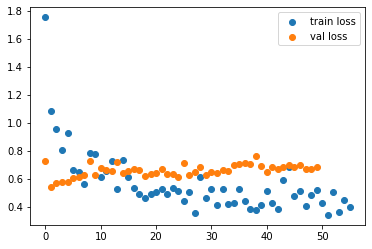

In [75]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

In [76]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
    print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9262844210771417}
val {'pearson_r2_score': 0.18442639606449354}
test {'pearson_r2_score': 0.45611072028064503}


So far these results show the best accuracy and they are comparable with the deeppurpose results of GCN for drug_encoding, target_encoding = 'DGL_GCN', 'CNN'